In [1]:
import sys

sys.path.insert(0, r"K:/Thesis/codes/crypto_project")
sys.path.insert(0, r"E:/Thesis/crypto_project")
import os
import sqlite3
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm

DATABASE_LOCATION = r"E:/Thesis/database"
from factor_model.model_update.database_generators import (
    FACTOR_MODEL_ESTIMATES,
    FIX_SET_OF_HALF_LIFES,
    SPECIFIC_RISK,
)
from factor_model.model_update.database_generators.generate_databases import (
    refresh_database,
)
import datetime
from factor_model.risk_calculations.core_universe_portfolio import (
    generate_market_portfolio,
)

EXPOSURE_NON_STYLE_FIELDS = [
    "id",
    "ticker",
    "return",
    "core_universe",
    "transformed_market_cap",
    "date",
]
from factor_model.model_update.database_generators import EXPOSURE_NON_STYLE_FIELDS

from factor_model.risk_calculations.risk_attribution import (
    create_portfolio_exposures,
    generate_factor_covariance_attribution,
    calculate_spec_risk_mctr,
    generate_factor_covariance_table,
    generate_active_space_portfolio,
    get_specific_risk_beta
)
from factor_model.risk_calculations.factor_covariance import (
    generate_factor_covariance_matrix,
)
from factor_model.risk_calculations.specific_risk import (
    generate_raw_specific_risk,
    generate_raw_portfolio_specific_risk
)
from factor_model.risk_calculations.risk_metrics import calculate_lognormal_es_var

#### USER INPUT example

In [2]:
# A sample portfolio to test calculations and restrict query...
portfolio_details = {
    "BCUBE-USD": 0.17,
    "LNC-USD": 0.05,
    "PMG24050-USD": 0.2,
    "ZNN-USD": 0.04,
    "EFI-USD": 0.03,
    "BTC-USD": 0.32,
    "ETH-USD": 0.19,
}

market_portfolio = {
    "BTC-USD": 0.31574372070244366,
    "ETH-USD": 0.18711055133973806,
    "USDT-USD": 0.08725061854643708,
    "BNB-USD": 0.06932395681724883,
    "SOL-USD": 0.06602083999170749,
    "STETH-USD": 0.0534749145676961,
    "XRP-USD": 0.05020181639431607,
    "USDC-USD": 0.046874562996328084,
    "ADA-USD": 0.04406750903164565,
    "DOGE-USD": 0.041257706928259585,
    "SHIB-USD": 0.03867380268417949,
}

# risk calculation
risk_calculation_parameters = {
    "correlation_half_life": 730,  # days
    "variance_half_life": 365,  # days
    "specific_risk_half_life": 365,
    "date": "2023-03-01",
    "minimum_history_spec_ret": 730,
}
# alias
cob_date = risk_calculation_parameters["date"]


#### 0. Load relevant input data
##### Ideally this should be supplied through Django db queries

In [3]:
with sqlite3.connect(
    os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)
) as conn:
    exposures = pd.read_sql_query(
        f"SELECT * FROM exposures where date = '{cob_date}'",
        conn,
    )

with sqlite3.connect(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)) as conn:
    factor_returns = pd.read_sql_query("SELECT * FROM factor_returns where date <= '{cob_date}'", conn)
    
# for spec risk (raw), only load relevant symbols
# prerequisite is the market_portolios constituents + user provided constituents
# date should also be supplied
if market_portfolio is None:
    market_portfolio = generate_market_portfolio(exposures)
all_tickers = list(set(market_portfolio.keys()).union(set(portfolio_details.keys())))
all_tickers_str = "','".join(all_tickers)
with sqlite3.connect(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)) as conn:
    full_specific_returns = pd.read_sql_query(
        f"SELECT * FROM specific_returns where date<='{cob_date}' and ticker in ('{all_tickers_str}')", conn)

In [4]:
#### TODO how the fuck do I know which factors are available???

#### 1. Calculate exposures

In [5]:
factor_covariance = generate_factor_covariance_matrix(factor_returns, risk_calculation_parameters)
active_space_port = generate_active_space_portfolio(portfolio_details, market_portfolio)

In [6]:
portolios = {
    "portfolio": portfolio_details,
    "market": market_portfolio,
    "active": active_space_port,
}

port_exposures = {}
factor_risks = {}
factor_attributions = {}
factor_covars = {}
raw_specific_risks = {}
spec_risk_availabilities = {}
spec_risks = {}
total_risks = {}
factor_mctrs = {}
spec_risk_attributions = {}
spec_risk_var_decomps = {}
spec_risk_mctrs = {}
for port in portolios.keys():
    # 1. exposure calc
    port_exposures[port] = create_portfolio_exposures(
        exposures=exposures, portfolio_details=portolios[port], non_style_fields=EXPOSURE_NON_STYLE_FIELDS
    )
    port_exposures[port] = port_exposures[port].reindex(factor_covariance.index)
    # 2. factor risk related
    (
        factor_risks[port],
        factor_attributions[port],
    ) = generate_factor_covariance_attribution(port_exposures[port], factor_covariance)
    factor_covars[port] = generate_factor_covariance_table(
        port_exposures[port], factor_covariance
    )
    # 3. spec risk related
    (
        raw_specific_risks[port],
        spec_risk_availabilities[port],
    ) = generate_raw_specific_risk(
        full_specific_returns, risk_calculation_parameters, portolios[port]
    )
    spec_risks[port] = generate_raw_portfolio_specific_risk(raw_specific_risks[port], portolios[port])
    total_risks[port] = np.sqrt(factor_risks[port]**2 + spec_risks[port]**2)
    
    factor_mctrs[port] = factor_attributions[port]/total_risks[port]
    spec_risk_attributions[port], spec_risk_var_decomps[port] = calculate_spec_risk_mctr(raw_specific_risks[port], portolios[port])
    spec_risk_mctrs[port] = spec_risk_attributions[port] / total_risks[port]
    
# 4. beta calculation...
factor_beta_covar, _ = generate_factor_covariance_attribution(port_exposures["portfolio"], factor_covariance, port_exposures["market"])
spec_risk_covar = get_specific_risk_beta(portolios["portfolio"], market_portfolio=portolios["market"], spec_risk= raw_specific_risks["active"])
portfolio_beta = (factor_beta_covar**2 + spec_risk_covar)/(total_risks["market"]**2)

# 5. expected shortfall calculation assuming normality, 1 Day
es95, var95 = calculate_lognormal_es_var(total_risks["portfolio"], 0.95)
es99, var99 = calculate_lognormal_es_var(total_risks["portfolio"], 0.99)


In [7]:
es99

0.1070890498454764

In [8]:
var99

0.09420560298450698

#### Plot stuff here

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.precision', 4)
pd.options.display.float_format = '{:,.4f}'.format


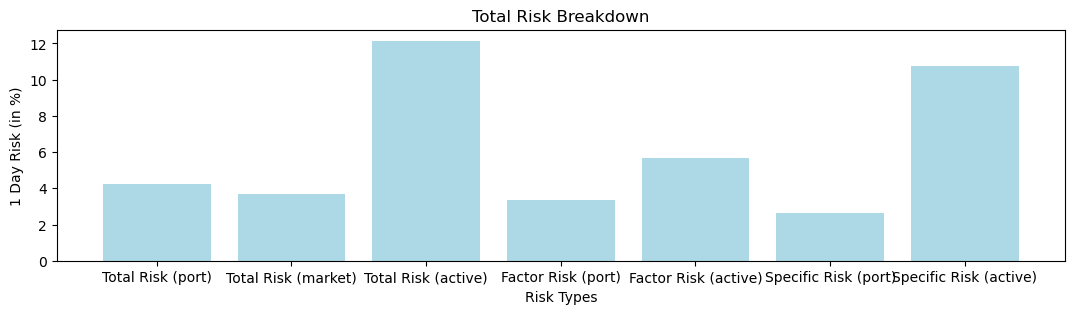

In [10]:
categories = ['Total Risk (port)', "Total Risk (market)", "Total Risk (active)",
              'Factor Risk (port)', 'Factor Risk (active)',
              'Specific Risk (port)', 'Specific Risk (active)']
values = [total_risks["portfolio"]*100, total_risks["market"]*100, total_risks["active"]*100,
          factor_risks["portfolio"]*100, factor_risks["active"]*100,
          spec_risks["portfolio"]*100, spec_risks["active"]*100
          ]
plt.figure(figsize=(13,3))
plt.bar(categories, values, color='lightblue')
plt.xlabel('Risk Types')
plt.ylabel('1 Day Risk (in %)')
plt.title('Total Risk Breakdown')
plt.show()

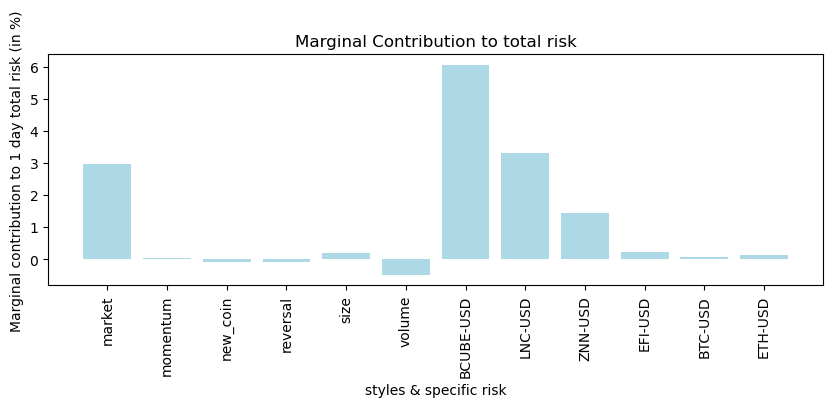

In [11]:
all_mctr = factor_mctrs["portfolio"].append(spec_risk_mctrs["portfolio"])
plt.figure(figsize=(10,3))
plt.bar(all_mctr.index, all_mctr*100, color='lightblue');
plt.ylabel('Marginal contribution to 1 day total risk (in %)')
plt.title('Marginal Contribution to total risk');
plt.xlabel('styles & specific risk')
plt.xticks(all_mctr.index, rotation=90);

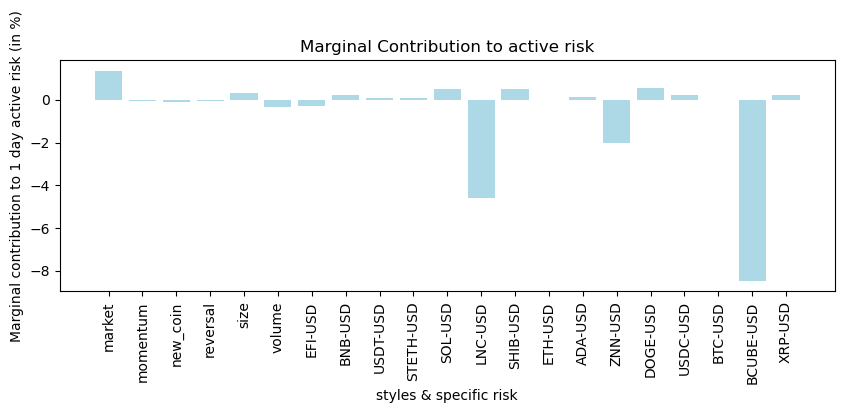

In [12]:
all_mctr = factor_mctrs["active"].append(spec_risk_mctrs["active"])
plt.figure(figsize=(10,3))
plt.bar(all_mctr.index, all_mctr*100, color='lightblue');
plt.ylabel('Marginal contribution to 1 day active risk (in %)')
plt.title('Marginal Contribution to active risk');
plt.xlabel('styles & specific risk')
plt.xticks(all_mctr.index, rotation=90);

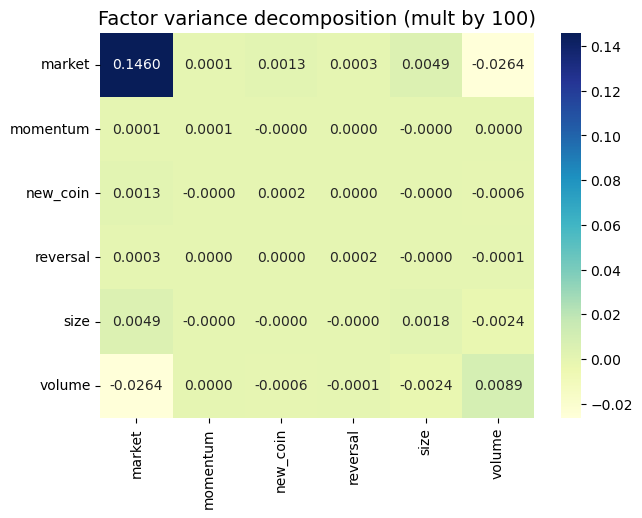

In [13]:
plt.figure(figsize=(7,5))
ax = sns.heatmap(factor_covars["portfolio"]*100,cmap="YlGnBu",annot=True, fmt=".4f")
plt.title("Factor variance decomposition (mult by 100)", fontsize=14);

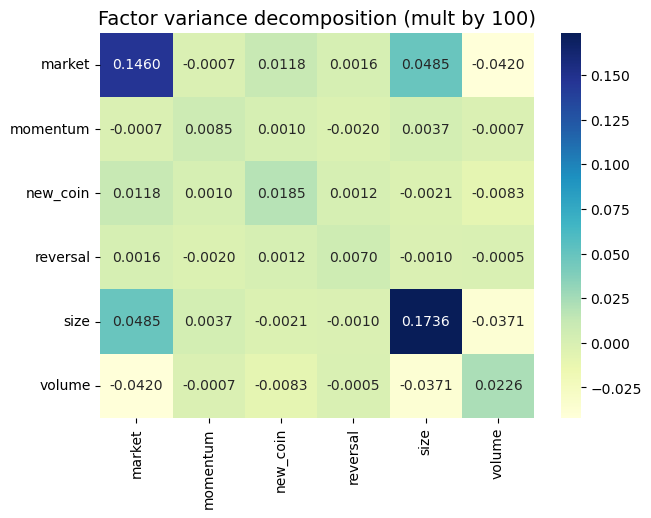

In [14]:
plt.figure(figsize=(7,5))
ax = sns.heatmap(factor_covars["active"]*100,cmap="YlGnBu",annot=True, fmt=".4f")
plt.title("Factor variance decomposition (mult by 100)", fontsize=14);